# CxC Project: Infinite Investments 

## Importing the necessary libraries

In [1]:
# Installing the necessary packages
!pip install LightGBM==4.0.0 --quiet
!pip install catboost --quiet
!pip install xgboost --quiet
output = !jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10;


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, recall_score,confusion_matrix, roc_auc_score, precision_score, f1_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 

In [3]:
#account_info = pd.read_csv("/work/account_data_info.csv")
df_train = pd.read_csv("/work/history.csv")
df_test = pd.read_csv("/work/test.csv")
print("Shape of trianing data set: {}\nShape of test data set: {}".format(df_train.shape, df_test.shape))

/tmp/ipykernel_144/1080880021.py:2: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("/work/history.csv")
/tmp/ipykernel_144/1080880021.py:3: DtypeWarning: Columns (62,64,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv("/work/test.csv")
Shape of trianing data set: (673339, 106)
Shape of test data set: (168335, 105)


## Preprocessing

Lets have a look for missing values in our dataset

In [4]:
# viewing percentage of missing data
def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

missing(df_train)

,Missing_Number,Missing_Percent
cashflows_custody_fee,673339,1.000000
esir_number,673327,0.999982
special_fee_code,673271,0.999899
function_code,669102,0.993707
country_code,669050,0.993630
...,...,...
fee_paid_separately,0,0.000000
custody_fee_withdrawal,0,0.000000
is_fee_exempt,0,0.000000
visible_in_reports,0,0.000000


`type_code` represents the Account Type of each client. There is a code called "Missing" which represents 3198 rows and has no inputs in the other columns. Similarly, `type_code` contains 237 blank inputs that also has no inputs in the other columns. These rows can be removed and are not significant.

In [5]:
# We will drop/remove all rows that are considered "Missing" in type_code
df_train = df_train.drop(df_train[df_train['type_code'] == 'MISSING'].index)

# We will omit all rows that are NaN in "type_code"
df_train = df_train[df_train['type_code'].notna()]

Many of our columns have >80% missing values. We will drop these and for the rest, we will impute with mean for our continuous data or impute with mode for categorical

In [6]:
df_train = df_train.drop(columns = ["cashflows_custody_fee",
"esir_number","special_fee_code","function_code","country_code",
"sss_agent","sss_location","sss_type","tms_settlement_location",
"conjunction","resp_specimen_plan","loan_limit_override","arp_pension_origin",
"special_tag","shareholder_language","plan_end_date","target_grantor_grantee_flag",
"non_plan_book_value_flag","retail_last_maintenance_user","plan_effective_date",
"number_of_beneficiaries","non_calendar_year_end","retail_plan","is_pledged","is_family_resp"])

# Applying same to 'test' date set
df_test = df_test.drop(columns = ["cashflows_custody_fee",
"esir_number", "special_fee_code","function_code","country_code",
"sss_agent","sss_location","sss_type","tms_settlement_location",
"conjunction","resp_specimen_plan","loan_limit_override","arp_pension_origin",
"special_tag","shareholder_language","plan_end_date","target_grantor_grantee_flag",
"non_plan_book_value_flag","retail_last_maintenance_user","plan_effective_date","number_of_beneficiaries",
"non_calendar_year_end","retail_plan","is_pledged","is_family_resp"])

In [7]:
# we will also ignore date and time columns. Since IDs are unique, including them in our model will lead to overfitting and they do not provide any insight.
df_train.drop(list(df_train.filter(regex='date|time')), axis=1, inplace=True)
df_train.drop(["id"], axis = 1, inplace = True)

# we do the same with 'test' data set
df_test.drop(list(df_test.filter(regex='date|time')), axis=1, inplace=True)
df_test_id = df_test["id"]
df_test.drop(["id"], axis = 1, inplace = True)

In [8]:
df_train.isna().sum() 

type_code                     0
is_registered                 0
currency_code                 0
is_active                     0
class_id                      0
                          ...  
is_plan_grandfathered    313555
inserted_at                   0
is_olob                       0
visible_in_reports            0
label                         0
Length: 72, dtype: int64

In [9]:
df_train.dtypes

type_code                 object
is_registered             object
currency_code             object
is_active                 object
class_id                 float64
                          ...   
is_plan_grandfathered     object
inserted_at               object
is_olob                   object
visible_in_reports        object
label                     object
Length: 72, dtype: object

`is_resp`, `is_hrdc_resp`, `is_plan_grandfathered`, `is_arp_locked` and `is_spousal` can provide valuable insight. We will replace blank rows with a third category to not lose data.

In [10]:
# replacing mentionned columns' blanks with "Blank"
replace_with_blank = ['is_resp', 'is_hrdc_resp', 'is_plan_grandfathered', 'is_arp_locked', 'is_spousal']

for col in replace_with_blank:
    df_train[col] = df_train[col].replace(np.nan, "Blank")
    # we do the same with 'test' data set
    df_test[col] = df_test[col].replace(np.nan, "Blank")   

`title` can give us valuable insight on which gender is more likely to churn. We will create a new column `Sex` to indicate whether customer is male or female based on `title` and drop it.

In [11]:
# function will look at the title of each customer and assign it as "Male" or "Female". If it is unclear then assigns as "Unisex"
def change_title_to_sex(row):
    Male = ['MONSIEUR', 'MR']
    Female = ['MADAME', 'MS.', 'MSS']
    if row.upper() in Female:
        return "Female"
    elif row.upper() in Male:
        return "Male"
    else:
        return "Unisex"

# first we convert the whole column to string type since it contains both stirngs and floats
df_train['title'] = df_train['title'].astype(str)

# we assign it to male or female and then drop `title`
df_train['Sex'] = df_train['title'].apply(change_title_to_sex)
df_train.drop('title', axis = 1, inplace = True)

# we do the same with 'test' data set
df_test['title'] = df_test['title'].astype(str)
df_test['Sex'] = df_test['title'].apply(change_title_to_sex)
df_test.drop('title', axis = 1, inplace = True)

Columns `contract_type`, `terminal_code`, `discretionary_trading_authorized`, `has_discrete_auth`, `risk_tolerance`, `investment_objective`  still have missing rows, we can impute with mode since they are all categorical.

In [12]:
remaining_cols = ['contract_type', 'terminal_code', 'discretionary_trading_authorized', 'has_discrete_auth', 'risk_tolerance', 'investment_objective']

for col in remaining_cols:
    df_train[col] = df_train[col].fillna(df_train[col].mode().iloc[0])
    # Applying to 'test' data set
    df_test[col] = df_test[col].fillna(df_test[col].mode().iloc[0])

### Viewing categorical and numerical data

In [13]:
categorical = df_train.select_dtypes('object').columns
numerical = df_train.select_dtypes('number').columns

categorical_dtest = df_test.select_dtypes('object').columns
numerical_dtest = df_test.select_dtypes('number').columns

print(f'Numerical Columns:  {df_test[numerical_dtest].columns} \nCategorical Columns: {df_test[categorical_dtest].columns}')


Numerical Columns:  Index(['class_id', 'contract_type', 'credit_limit_type',
       'dividend_confirm_code', 'options_trading_type', 'rep_commission_rate',
       'rep_commission_override', 'interest_dividend_conversion_type',
       'guarantee_gtor_type', 'deceased_fair_market_value',
       'portfolio_cost_method', 'portfolio_report_option',
       'interactive_portfolio_code', 'mailing_consent'],
      dtype='object') 
Categorical Columns: Index(['type_code', 'is_registered', 'currency_code', 'is_active',
       'debit_code', 'net_of_fees', 'fee_paid_separately',
       'custody_fee_withdrawal', 'is_fee_exempt', 'branch',
       'include_client_consolidation', 'use_client_address', 'is_spousal',
       'is_arp_locked', 'language_code', 'is_midwest_clearing_account',
       'use_hand_delivery', 'use_mail', 'share_name_address_to_issuer',
       'shareholder_instructions_received', 'rrsp_limit_reached',
       'is_portfolio_account', 'has_no_min_commission', 'is_tms_eligible',
       

Let's view if in the list of 'numerical' columns, the inputs are truly numerical or numbers representing categories.

In [14]:
for col in numerical:
    print("{}: ".format(col), df_train[col].unique())

class_id:  [ 3.  5. 39.  6.  8. 30.  7. 10.  2. 28. 56. 14. 11. 29.  1. 21. 75. 60.
 22. 19. 58. 31. 33. 32. 12. 18. 42. 48. 16. 38. 20. 53. 70.  4. 26. 61.
 57.  9. 36. 17. 40. 54. 43. 74. 44. 51. 49. 50. 27. 67. 41. 47. 52. 15.
 63. 23. 65. 13. 35. 71. 59. 62. 25. 34.]
contract_type:  [17. 18. 16. 12.  9.  8. 11.  7. 10.  0.  2.  4. 14.  3.  6.  1. 15. 13.
  5.]
credit_limit_type:  [0. 3. 9. 2. 7.]
dividend_confirm_code:  [0. 7. 5. 1. 6. 9.]
options_trading_type:  [0. 2. 4. 3. 1. 7.]
rep_commission_rate:  [0.]
rep_commission_override:  [ 0. 99.]
interest_dividend_conversion_type:  [0. 1.]
guarantee_gtor_type:  [0. 2. 3. 1.]
deceased_fair_market_value:  [   0.    654.36 2153.18 ... 1206.73  669.79  742.83]
portfolio_cost_method:  [0.]
portfolio_name_address_option:  [0.]
portfolio_report_option:  [0. 3. 2. 4.]
portfolio_summary_option:  [0.]
interactive_portfolio_code:  [0.]
mailing_consent:  [0. 1.]


* We notice that of the 'numerical' columns, there are numbers representing categories. So these columns should be considered categorical.
* We also notice that some columns contain only 0 or NaN. These columns should be removed as they will not provide valuable insight even after imputing with mode.
* `class_id` is unique. NaN will be replaced with mode.

In [15]:
change_NaN = ["portfolio_cost_method",
"portfolio_name_address_option",
"portfolio_summary_option",
"interactive_portfolio_code",
"rep_commission_rate"]

for col in change_NaN:
    df_train[col] = df_train[col].replace(np.nan, 1)
    df_test[col] = df_test[col].replace(np.nan, 1)



Some data in numerical list are categorical and are missing values, so we will replace blanks with the mode of the categories. While for
numerical values, we will replace blank with their mean.

Some columns only have 1 unique value. We will check if there are additional nan fields and remove them otherwise.

In [16]:
replace_with_mean = ['deceased_fair_market_value']
replace_with_mode = ["contract_type",
"terminal_code",
"discretionary_trading_authorized",
"is_resp",
"is_hrdc_resp",
"is_plan_grandfathered"]

def replace_mode(df, l):
    for col in l:
        mode = df[col].mode
        df[col].replace(np.nan, mode)
        df[col].fillna(mode)

def replace_mean(df, l):
    for col2 in l:
        mu = df[col2].mean
        df[col2].replace(np.nan, mu)

# applying to 'training' data set
replace_mean(df_train, replace_with_mean)
replace_mode(df_train, replace_with_mode)

# applying to'test' data set
replace_mean(df_test, replace_with_mean)
replace_mode(df_test, replace_with_mean)

In [17]:
unique_counts = df_train[categorical].nunique()
grouped_columns = unique_counts.groupby(unique_counts).groups
Col_with_1_unique = list(grouped_columns[1])

for col in Col_with_1_unique:
    print("{}: ".format(col), df_train[col].unique())
    
col_to_be_dropped = ["net_of_fees", "fee_paid_separately", "custody_fee_withdrawal", "is_fee_exempt","rrsp_limit_reached",
"is_portfolio_account", "has_no_min_commission","is_parameters_account","spousal_age_flag","is_broker_account",
"is_gl_account","is_control_account", "is_midwest_clearing_account","dup_trip_quad_code", "has_discrete_auth"]

net_of_fees:  ['f']
fee_paid_separately:  ['f']
custody_fee_withdrawal:  ['f']
is_fee_exempt:  ['f']
is_midwest_clearing_account:  [False]
rrsp_limit_reached:  ['f']
is_portfolio_account:  ['f']
has_no_min_commission:  ['f']
is_parameters_account:  ['f']
spousal_age_flag:  ['f']
dup_trip_quad_code:  ['A' nan]
has_discrete_auth:  ['f']
is_broker_account:  ['f']
is_gl_account:  ['f']
is_control_account:  ['f']


In [18]:
# dropping the columns with only singular inputs as they do not provide much insight
df_train = df_train.drop(columns = col_to_be_dropped)
df_test = df_test.drop(columns = col_to_be_dropped)


## Encoding

Lastly, we will use one-hot encoding and label encoding to convert our categorical columns into numerical values. one-hot encoding for > 2 unique values, label for 2 unique values

In [19]:
Col_with_2_unique = list(grouped_columns[2])

Now we check for columns with > 2 unique values. We will use label encoding if the values have inherent order and one-hot encoding if there isn't.

In [20]:
Col_with_more_2_unique = [value for key, value in grouped_columns.items() if key > 2]

Col_with_more_2_unique = ['branch','type_code', 'debit_code','is_spousal', 'is_arp_locked', 'discretionary_trading_authorized',
'is_resp','is_hrdc_resp', 'Sex']

#might be able to get more information by parsing risk_tolerance and investment objective. Drop in the meantime
Col_with_too_many_unique = ['inserted_at','last_maintenance_user','risk_tolerance','terminal_code' ,'investment_objective']
df_train.drop(Col_with_too_many_unique, axis=1, inplace=True)

# Applying same to 'test' data set
df_test.drop(Col_with_too_many_unique, axis=1, inplace=True)
print(Col_with_more_2_unique)

['branch', 'type_code', 'debit_code', 'is_spousal', 'is_arp_locked', 'discretionary_trading_authorized', 'is_resp', 'is_hrdc_resp', 'Sex']


Start the encoding

In [21]:
#df_train.dtypes
#print(df_train[columns_to_labelencode].dtypes)
#print(df_train['has_discrete_auth'].unique())

Col_with_2_unique_less_label = [x for x in Col_with_2_unique if x != 'label']

# Label Encoding
label_encoder = LabelEncoder()
for column in Col_with_2_unique:
    df_train[column] = label_encoder.fit_transform(df_train[column])
    
# Applying same to 'test' data set
for column in Col_with_2_unique_less_label:   
    df_test[column] = label_encoder.fit_transform(df_test[column])    

# One Hot Encoding
oneHotEncodelist = Col_with_more_2_unique
df_encoded = pd.get_dummies(df_train[oneHotEncodelist], drop_first=True)
df_train = pd.concat([df_train, df_encoded], axis=1)
df_train.drop(oneHotEncodelist, axis=1, inplace=True)

# Applying same to 'test' data set
df_test_encoded = pd.get_dummies(df_test[oneHotEncodelist], drop_first=True)
df_test = pd.concat([df_test, df_test_encoded], axis=1)
df_test.drop(oneHotEncodelist, axis=1, inplace=True)


In [22]:
current_col_used = ["is_registered",
"currency_code",
"is_active",
"class_id",
"contract_type",
"include_client_consolidation",
"use_client_address",
"credit_limit_type",
"language_code",
"dividend_confirm_code",
"options_trading_type",
"rep_commission_rate",
"rep_commission_override",
"interest_dividend_conversion_type",
"guarantee_gtor_type",
"use_hand_delivery",
"use_mail",
"share_name_address_to_issuer",
"shareholder_instructions_received",
"is_tms_eligible",
"is_agent_bbs_participant",
"is_spousal_transfer",
"has_multiple_name",
"deceased_fair_market_value",
"iso_funds_code",
"portfolio_cost_method",
"portfolio_name_address_option",
"portfolio_report_option",
"portfolio_summary_option",
"receive_general_mailings",
"interactive_portfolio_code",
"is_non_objecting_beneficial_owner",
"is_objecting_to_disclose_info",
"mailing_consent",
"consent_to_pay_for_mail",
"consent_to_email_delivery",
"has_received_instruction",
"is_inventory_account",
"is_extract_eligible",
"is_plan_grandfathered",
"is_olob",
"visible_in_reports",
"branch",
"type_code",
"debit_code",
"is_spousal",
"is_arp_locked",
"is_hrdc_resp",
"Sex"]
print(len(current_col_used))

49


We noticed that, of the columns included in our 'numerical' list, not all of them are truly numerical but just have numbers to represent categories.

#### Seperating independent and dependent features

In [23]:
df_train[["label"]] = df_train[["label"]].replace({'Churn': 1, 'No Churn': 0}) #replace string with value for prediction

y = df_train[["label"]]#replace string with value for prediction

X= df_train.drop('label', axis=1)
#X = X.drop(X[categorical], axis=1)

## Model fitting

Since we are dealing with imbalanced data (unequal number of churns and no churns), we have to establish our scale_pos_weight

In [24]:
spw_numerator = (df_train['label'] == 0).sum()
spw_denominator = (df_train['label'] == 1).sum()
ratio = round(spw_numerator/spw_denominator, 2)

print("Our scale_pos_weight is: {}".format(ratio))

Our scale_pos_weight is: 3.97


Splitting the dataset into training and testing

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=42)

## Model: XGBoost

### XGBoost Accuracy

In [26]:
xgb = XGBClassifier(random_state=0,scale_pos_weight=ratio)
xgb.fit(X_train, y_train)
y_pred_xgbm = xgb.predict(X_test)

accuracy_xgb = []
recall_xgb = []
roc_auc_xgb = []
precision_xgb = []
f1_xgb = []

In [27]:
accuracy_xgb.append(round(accuracy_score(y_test, y_pred_xgbm),4))
recall_xgb.append(round(recall_score(y_test, y_pred_xgbm),4))
roc_auc_xgb.append(round(roc_auc_score(y_test, y_pred_xgbm),4))
precision_xgb.append(round(precision_score(y_test, y_pred_xgbm),4))
f1_xgb.append(round(f1_score(y_test, y_pred_xgbm),4))

### XGBoost Confusion Matrix

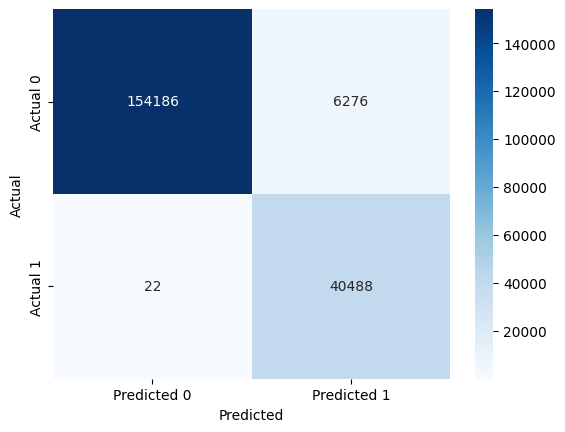

In [28]:
# Creating a confusion matrix for LGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgbm)

sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Model: LGBMClassifier

### LGBM Accuracy

In [29]:
lgbmc=LGBMClassifier(random_state=0, scale_pos_weight = ratio)

lgbmc.fit(X_train, y_train)
y_pred_lgbm = lgbmc.predict(X_test)

/shared-libs/python3.11/py/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/shared-libs/python3.11/py/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 94384, number of negative: 374548
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 

In [30]:
accuracy_lgbm = []
recall_lgbm = []
roc_auc_lgbm = []
precision_lgbm = []
f1_lgbm = []

accuracy_lgbm.append(round(accuracy_score(y_test, y_pred_lgbm),4))
recall_lgbm.append(round(recall_score(y_test, y_pred_lgbm),4))
roc_auc_lgbm.append(round(roc_auc_score(y_test, y_pred_lgbm),4))
precision_lgbm.append(round(precision_score(y_test, y_pred_lgbm),4))
f1_lgbm.append(round(f1_score(y_test, y_pred_lgbm),4))


### LGBM Confusion Matrix

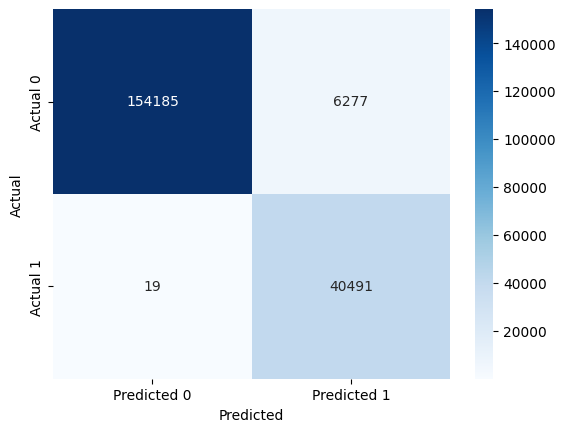

In [31]:
# Creating a confusion matrix for LGBoost
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

sns.heatmap(cm_lgbm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Model: Random Forest

### Random Forest Accuracy

In [32]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train.values.ravel())
forest_pred = clf.predict(X_test)

accuracy_clf = []
recall_clf = []
roc_auc_clf = []
precision_clf = []
f1_clf = []

In [33]:
accuracy_clf.append(round(accuracy_score(y_test, forest_pred),4))
recall_clf.append(round(recall_score(y_test, forest_pred),4))
roc_auc_clf.append(round(roc_auc_score(y_test, forest_pred),4))
precision_clf.append(round(precision_score(y_test, forest_pred),4))
f1_clf.append(round(f1_score(y_test, forest_pred),4))

cm = confusion_matrix(y_test, forest_pred)
cm

array([[154254,   6208],
       [   298,  40212]])

### Random Forest Confusion Matrix

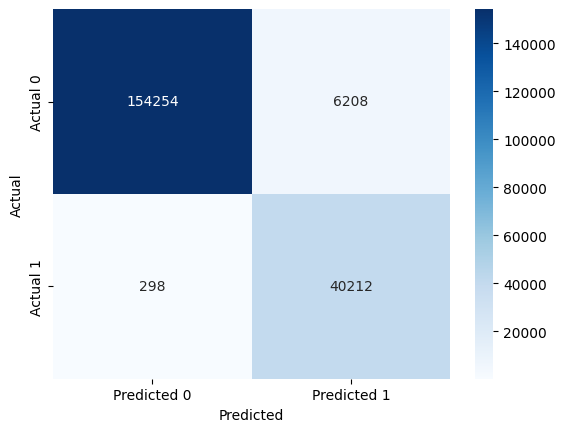

In [34]:
# Creating a confusion matrix for random forest
cm_clf = confusion_matrix(y_test, forest_pred)

sns.heatmap(cm_clf, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Model: CatBoost

### Catboost Accuracy

In [35]:
catboost = CatBoostClassifier(verbose=False,random_state=0,scale_pos_weight=ratio)
catboost.fit(X_train, y_train)
catboost_pred = catboost.predict(X_test)

accuracy_catboost = []
recall_catboost = []
roc_auc_catboost = []
precision_catboost = []
f1_catboost = []


In [36]:
accuracy_catboost.append(round(accuracy_score(y_test, catboost_pred),4))
recall_catboost.append(round(recall_score(y_test, catboost_pred),4))
roc_auc_catboost.append(round(roc_auc_score(y_test, catboost_pred),4))
precision_catboost.append(round(precision_score(y_test, catboost_pred),4))
f1_catboost.append(round(f1_score(y_test, catboost_pred),4))

### Catboost Confusion Matrix

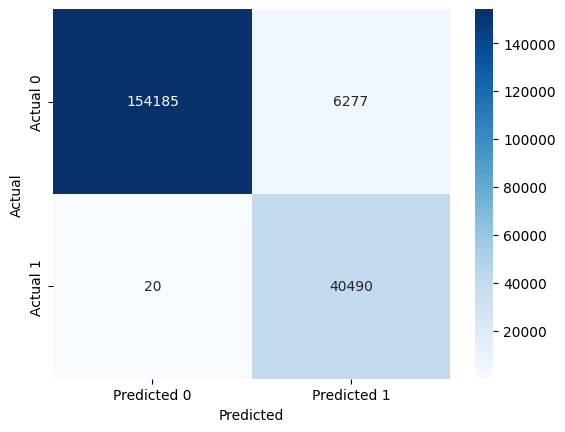

In [37]:
cm_catboost = confusion_matrix(y_test, catboost_pred)

sns.heatmap(cm_catboost, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Model: Neural Network

In [38]:
# attempt 2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout

# Assuming you have a dataframe df with 10 features and a target variable 'churn'

# Extract features and target variable
X_LSTM_train = np.asarray(X_train.values).astype('float64')
y_LSTM_train = y_train.values

# Reshape the data to fit the Bidirectional LSTM layer
X_LSTM_train = X_LSTM_train.reshape(X_LSTM_train.shape[0], 1, X_LSTM_train.shape[1])

# Create a Sequential model
model = Sequential()

# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_LSTM_train.shape[1], X_LSTM_train.shape[2])))
model.add(Bidirectional(LSTM(32)))

# Optional: Add Dropout for regularization
model.add(Dropout(0.5))

# Dense layers for final prediction
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification, predicting churn or not

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model to your data
model.fit(X_LSTM_train, y_LSTM_train, epochs=10, batch_size=32, validation_split=0.2)

2024-02-24 00:01:36.027690: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-24 00:01:36.029999: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-24 00:01:36.056895: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 00:01:36.056938: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 00:01:36.056961: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [39]:
X_LSTM_test = np.asarray(X_test.values).astype('float64')
X_LSTM_test = X_LSTM_test.reshape(X_LSTM_test.shape[0], 1, X_LSTM_test.shape[1])

# Make predictions
LSTM_pred = model.predict(X_LSTM_test)

# The predictions will be probabilities; you may round them to obtain binary predictions
LSTM_binary_pred = (LSTM_pred > 0.5).astype(int)

6281/6281 [==============================] - 18s 3ms/step


### Neural Network Accuracy

In [40]:
LSTM_binary_pred_flat = LSTM_binary_pred.flatten()
f1_score(list(LSTM_binary_pred_flat),y_test)

0.9268281488451079

In [41]:
loss, accuracy = model.evaluate(X_LSTM_test, y_test)
print(f'Testing Set - Loss: {loss}, Accuracy: {accuracy}')

6281/6281 [==============================] - 18s 3ms/step - loss: 0.0929 - accuracy: 0.9683
Testing Set - Loss: 0.09286361187696457, Accuracy: 0.9682692289352417


Overall the neural network looks to have an f1_score of 0.9277, a little worse compared to Cat and LGBM boost. This is definitely because we are not able to do much hyperparameter tuning for our model.

In [42]:
result = pd.DataFrame({'Accuracy':accuracy_xgb+accuracy_lgbm+accuracy_clf+accuracy_catboost, 
                        'Recall': recall_xgb + recall_lgbm + recall_clf + recall_catboost, 
                        'Roc_Auc': roc_auc_xgb + roc_auc_lgbm + roc_auc_clf +roc_auc_catboost, 
                        'Precision': precision_xgb + precision_lgbm + precision_clf + precision_catboost, 
                        'f1': f1_xgb + f1_lgbm + f1_clf +f1_catboost}, 
                        index=['XGBoost Classifier', 'LGBM Classifier', 'Random Forest', 'Catboost'])

result

,Accuracy,Recall,Roc_Auc,Precision,f1
XGBoost Classifier,0.9687,0.9995,0.9802,0.8658,0.9278
LGBM Classifier,0.9687,0.9995,0.9802,0.8658,0.9279
Random Forest,0.9676,0.9926,0.9770,0.8663,0.9252
Catboost,0.9687,0.9995,0.9802,0.8658,0.9279


From the table above, we find that all our models give similar results with values in the upper 80s and mid 90s.
We found that the `Catboost` provided marginally better results in terms of recall at 0.9996 and f1 score and 0.9279.

## Prediction on the test dataset

We noticed the dtypes for two columns in df_test is not the same as  df_train.
* `portfolio_name_address_option ` contains 'A' and will be replaced with 0. The column will change dtype from `object` to `float64`
* `portfolio_summary_option` contains 'T' and will be replaced with 0. The column will change dtype from `object` to `float64`

In [43]:
X.dtypes

is_registered       int64
currency_code       int64
is_active           int64
class_id          float64
contract_type     float64
                   ...   
is_resp_t            bool
is_hrdc_resp_f       bool
is_hrdc_resp_t       bool
Sex_Male             bool
Sex_Unisex           bool
Length: 101, dtype: object

In [44]:
df_test.dtypes

is_registered       int64
currency_code       int64
is_active           int64
class_id          float64
contract_type     float64
                   ...   
is_resp_t            bool
is_hrdc_resp_f       bool
is_hrdc_resp_t       bool
Sex_Male             bool
Sex_Unisex           bool
Length: 93, dtype: object

In [45]:
columns_to_convert = ['portfolio_name_address_option', 'portfolio_summary_option']

df_test['portfolio_name_address_option'].replace('A', '0', inplace=True)
df_test['portfolio_summary_option'].replace('T', '0', inplace=True)
print(df_test['portfolio_name_address_option'].unique())
print(df_test['portfolio_summary_option'].unique())

df_test[columns_to_convert] = df_test[columns_to_convert].astype('float64')

[0.0 1 '0' '0.0']
[0.0 1 '0' '0.0']


In [46]:
features_train = set(df_train.columns)
features_test = set(df_test.columns)

# Find the differences
differences_train_test = features_train - features_test
differences_test_train = features_test - features_train
print(differences_train_test,differences_test_train)

{'debit_code_V', 'debit_code_L', 'debit_code_1', 'label', 'branch_IND ALLI', 'debit_code_G', 'debit_code_E', 'debit_code_Z', 'debit_code_7', 'debit_code_B'} {'type_code_MISSING'}


Since certain debit_codes and branch IDs are missing in the test data, we have to add them after encoding and reordering the columns.

In [47]:
new_columns = {'debit_code_Z': False, 'debit_code_G': False, 'debit_code_E': False, 'debit_code_1': False, 'debit_code_B': False, 'branch_IND ALLI': False
,'debit_code_V': False, 'debit_code_L': False, 'debit_code_7': False}
df_test = df_test.assign(**new_columns)
df_test_reordered = df_test[X_train.columns]

test_pred = catboost.predict(df_test_reordered)

In [56]:
solution = pd.DataFrame({'id':df_test_id, 'predicted':test_pred })
solution.set_index('id', inplace=True)
answers = solution.to_csv("answers.csv")

## Reflection

After finishing our submissions, we did a quick reflection on how we could have done our analysis better.

- Additional variates + analyzing numerical ones:

We could've done more research to develop additional variables using the ones provided. Additionally, we did not have time to analyze the numerical variables closer and perform more preprocessing like normalizing.

- Deeper analysis of the dropped columns

To save more time, we directly dropped columns that have 80%> missing variables and other columns that have issues that prevent fits and predictions. We would like to be able to develop deeper and perform more research into whether we could have used those columns or not.

- More variety of models and certain hyper-tuning

 Due to the limited resources provided to our notebook, we are unable to build a wide variety of models and perform hyper-tuning on them. Our next steps might be to build and tune the models locally.

# Objective 2: Creativity of Marketing Strategies

We will be using Cramér's V to find the association between our independent variables and our target variable (Churn/No Churn). Cramér's V is based on Pearson's Chi-squared statistic and will give a value between 0 and 1 inclusive. 0 represents complete independence while 1 represents complete dependence.

In [49]:
from scipy.stats import chi2_contingency

# Initialise our categorical features from df_test and our target variable 'Churn' is represented by the integer 1
categorical_features = list(df_test.columns)
target_variable = 1

df_cramersV = {'Feature': [], 'Cramers_V': []}

# Finding the Cramer's V for each feature
for feature in categorical_features:
    contingency_table = pd.crosstab(df_test[feature], test_pred)
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    if p < 0.05:  # Check if the association is significant
        v = (chi2 / df_test.shape[0])**0.5
        df_cramersV['Feature'].append(feature)
        df_cramersV['Cramers_V'].append(v)

# Converting it to a dataframe
df_cramersV = pd.DataFrame(df_cramersV)

# displaying the data
df_cramersV

,Feature,Cramers_V
0,is_registered,0.507769
1,currency_code,0.097572
2,is_active,0.151758
3,class_id,0.518301
4,contract_type,0.159546
...,...,...
69,is_arp_locked_t,0.134370
70,is_resp_f,0.478862
71,is_resp_t,0.110890
72,is_hrdc_resp_f,0.480832


We will look at the top 10 features affecting Churn

In [50]:
top_features = df_cramersV.sort_values(by='Cramers_V', ascending=False).head(10)

top_features

,Feature,Cramers_V
59,debit_code_A,0.604934
35,visible_in_reports,0.603947
6,use_client_address,0.537388
33,is_plan_grandfathered,0.520471
3,class_id,0.518301
0,is_registered,0.507769
13,guarantee_gtor_type,0.504835
72,is_hrdc_resp_f,0.480832
70,is_resp_f,0.478862
66,is_spousal_f,0.460823


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1815e5ca-390c-46c1-8e56-e56ef11b9b11' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>